## Q1. Web Scraping the wikipedia page to prepapre dataframe of postal codes and neighborhoods

In [1]:
#!conda install -c conda-forge beautifulsoup4 --yes
#!conda install -c conda-forge lxml --yes
#!conda install -c conda-forge folium --yes
#!conda install -c conda-forge geopy --yes

In [2]:
import bs4 as bs
import lxml
import urllib.request
import pandas as pd
import numpy as np

#### Read the url, find table and rows

In [3]:
#open the wiki url and read it
source = urllib.request.urlopen('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').read()
soup = bs.BeautifulSoup(source,'lxml')

#find the table isntance in the source
table = soup.find('table')
#find row html tags in the table
table_rows = table.find_all('tr')

In [4]:
Canada = []
#find each td table data/cells in each row and append the text values to canada list 
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text.rstrip() for i in td]
    Canada.append(row)

#### Prepare the dataframe from the extracted table rows and cells

In [5]:
#split the canada list into 3 more lists, 1 each for postalcode, borough and neighborhood. Pass these 3 lists as coloumns to the dataframe
PostalCode = []
Borough = []
Neighborhood = []

for i in range(1,len(Canada)):
    PostalCode.append(Canada[i][0]) 
    Borough.append(Canada[i][1])
    Neighborhood.append(Canada[i][2])

Canada_df = pd.DataFrame()
Canada_df['PostalCode'] = PostalCode
Canada_df['Borough'] = Borough
Canada_df['Neighborhood'] = Neighborhood

print(Canada_df.shape)
Canada_df.head()

(287, 3)


,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### Drop the rows which has 'Not assigned' Borough value

In [6]:
#set Borough as index, drop those borough which has Not assigned values, reset the index back
Canada_df = Canada_df.set_index('Borough')
Canada_df.drop("Not assigned", axis = 0, inplace = True)
Canada_df = Canada_df.reset_index()
Canada_df = Canada_df[["PostalCode","Borough","Neighborhood"]]
Canada_df.head(7)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor
5,M7A,Downtown Toronto,Queen's Park
6,M9A,Queen's Park,Not assigned


#### Where Neighborhood is not assigned, replace it with Borough value

In [7]:
#check how many rows has not assigned neighborhood value. Only 1
Canada_df.index[Canada_df["Neighborhood"] == "Not assigned"].tolist()

[6]

In [8]:
#replace the value
Canada_df.Neighborhood.replace("Not assigned",Canada_df.Borough,inplace=True)
Canada_df.head(7)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor
5,M7A,Downtown Toronto,Queen's Park
6,M9A,Queen's Park,Queen's Park


In [9]:
#After replace, check again if any rows has not assigned in neighborhood and print those index. None
Canada_df.index[Canada_df["Neighborhood"] == "Not assigned"].tolist()

[]

#### Final shape of the dataframe

In [10]:
Canada_df.shape

(210, 3)

<h1>Q2 Merge cordinates csv with the dataframe prepared above to get the final dataframe with all required columns</h1>

#### I tried to get cordinates using geocoder code but I got timeout error and it didn't work. So I went ahead and used the csv file provided

In [11]:
#read the csv file provided into a dataframe
geocord_df = pd.read_csv("http://cocl.us/Geospatial_data")
geocord_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Merge both dataframes based on postalcode column

In [12]:
#merge dataframes and drop the redundant postal code column
Canada_df = Canada_df.merge(geocord_df, left_on='PostalCode', right_on='Postal Code')
Canada_df.drop('Postal Code', axis=1, inplace=True)
Canada_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Heights,43.718518,-79.464763
4,M6A,North York,Lawrence Manor,43.718518,-79.464763


#### Final size of the dataframe

In [13]:
Canada_df.shape

(210, 5)

<h1>Q3 Explore the Tronto Boroughs using the FourSquare API. Cluster and Segment the neighborhoods</h1>

In [14]:
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 

print('Libraries imported.')

Libraries imported.


In [15]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['source', 'table']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<h4> For simple visualization, I'm taking only those Boroughs which contain 'Toronto' in it's name </h4>

In [16]:
Toronto_data = Canada_df[Canada_df['Borough'].str.contains("Toronto")].reset_index(drop=True)
Toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
1,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
2,M5B,Downtown Toronto,Ryerson,43.657162,-79.378937
3,M5B,Downtown Toronto,Garden District,43.657162,-79.378937
4,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418


##### Get geographical cordinates for Toronto

In [17]:
address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


##### Map of boroughs with Toronto in it's name and neighborhoods in them

In [18]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Toronto_data['Latitude'], Toronto_data['Longitude'], Toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Since folium maps are not rendering on GitHub. I took a screenshot of the map and added the image here. If you wish to see the dynamic map, then please copy the link of this notebook and use it on https://nbviewer.jupyter.org/

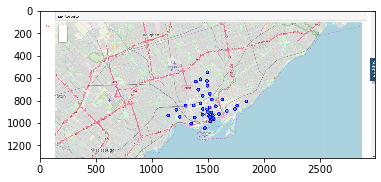

In [19]:
img_t=mpimg.imread('map_Toronto.JPG')
imgplot_t = plt.imshow(img_t)
plt.show()

<h4> To explore and  segment the neighborhoods, I'm using Foursquare API </h4>

In [42]:
#Define foursquare credential and verion

CLIENT_ID = 'I removed my credentials after completing the assignment' # your Foursquare ID
CLIENT_SECRET = 'I removed my credentials after completing the assignment' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: I removed my credentials after completing the assignment
CLIENT_SECRET:I removed my credentials after completing the assignment


#### Get the top 100 venues that are in Toronto Boroughs neighborhoods within a radius of 500 meters.

In [21]:
#function to extact top 100 venues  in all neighborhoods

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the above function on each neighborhood and create a new dataframe called *Toronto_venues*.

In [22]:
Toronto_venues = getNearbyVenues(names=Toronto_data['Neighborhood'],
                                   latitudes=Toronto_data['Latitude'],
                                   longitudes=Toronto_data['Longitude']
                                  )


Harbourfront
Queen's Park
Ryerson
Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Harbourfront East
Toronto Islands
Union Station
Little Portugal
Trinity
The Danforth West
Riverdale
Design Exchange
Toronto Dominion Centre
Brockton
Exhibition Place
Parkdale Village
The Beaches West
India Bazaar
Commerce Court
Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North
Forest Hill West
High Park
The Junction South
North Toronto West
The Annex
North Midtown
Yorkville
Parkdale
Roncesvalles
Davisville
Harbord
University of Toronto
Runnymede
Swansea
Moore Park
Summerhill East
Chinatown
Grange Park
Kensington Market
Deer Park
Forest Hill SE
Rathnelly
South Hill
Summerhill West
CN Tower
Bathurst Quay
Island airport
Harbourfront West
King and Spadina
Railway Lands
South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown
St. James Town
First Canadian Place
Underground city

In [23]:
#size of the dataframe
print(Toronto_venues.shape)
Toronto_venues.head()

(3237, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Cooper Koo Family YMCA,43.653191,-79.357947,Gym / Fitness Center
3,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Harbourfront,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


In [24]:
#check how many venues were returned for each neighborhood
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adelaide,100,100,100,100,100,100
Bathurst Quay,16,16,16,16,16,16
Berczy Park,56,56,56,56,56,56
Brockton,22,22,22,22,22,22
Business Reply Mail Processing Centre 969 Eastern,17,17,17,17,17,17
CN Tower,16,16,16,16,16,16
Cabbagetown,44,44,44,44,44,44
Central Bay Street,79,79,79,79,79,79
Chinatown,84,84,84,84,84,84


In [25]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 236 uniques categories.


### Analyze Each Neighborhood

In [26]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Harbourfront,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0

In [27]:
Toronto_onehot.shape

(3237, 236)

In [28]:
#Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Adelaide,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.020000,0.000000,0.00,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.040000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.020000,0.0000,0.01,0.020000,0.000000,0.000000,0.01,0.020000,0.010000,0.00,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.060000,0.000000,0.000,0.000000,0.00,0.01,0.000000,0.000000,0.020000,0.00,0.000000,0.020000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0

In [29]:
Toronto_grouped.shape

(73, 236)

##### Let's print each neighborhood along with the top 5 most common venues

In [30]:
num_top_venues = 5

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide----
             venue  freq
0      Coffee Shop  0.06
1             Café  0.04
2  Thai Restaurant  0.04
3       Steakhouse  0.04
4              Bar  0.04


----Bathurst Quay----
              venue  freq
0    Airport Lounge  0.12
1  Airport Terminal  0.12
2             Plane  0.06
3   Harbor / Marina  0.06
4     Boat or Ferry  0.06


----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1              Bakery  0.04
2                Café  0.04
3  Seafood Restaurant  0.04
4          Steakhouse  0.04


----Brockton----
                venue  freq
0                Café  0.14
1      Breakfast Spot  0.09
2         Coffee Shop  0.09
3       Grocery Store  0.05
4  Italian Restaurant  0.05


----Business Reply Mail Processing Centre 969 Eastern----
              venue  freq
0       Yoga Studio  0.06
1     Auto Workshop  0.06
2              Park  0.06
3        Comic Shop  0.06
4  Recording Studio  0.06


----CN Tower----
              venue  freq
0    Airport Lo

In [31]:
#function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
#Create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Thai Restaurant,Bar,Steakhouse,Café,Bakery,Restaurant,Sushi Restaurant,Concert Hall,Burger Joint
1,Bathurst Quay,Airport Lounge,Airport Terminal,Boutique,Harbor / Marina,Boat or Ferry,Rental Car Location,Bar,Coffee Shop,Plane,Sculpture Garden
2,Berczy Park,Coffee Shop,Seafood Restaurant,Cheese Shop,Farmers Market,Beer Bar,Bakery,Steakhouse,Cocktail Bar,Café,Fountain
3,Brockton,Café,Breakfast Spot,Coffee Shop,Climbing Gym,Burrito Place,Restaurant,Japanese Restaurant,Stadium,Italian Restaurant,Intersection
4,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Fast Food Restaurant,Auto Workshop,Burrito Place,Recording Studio,Spa,Restaurant,Brewery,Smoke Shop,Pizza Place


## Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [33]:
# set number of clusters
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 3, 1, 1, 1, 3, 1, 1, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [34]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = Toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,1,Coffee Shop,Bakery,Pub,Park,Theater,Mexican Restaurant,Breakfast Spot,Restaurant,Café,Shoe Store
1,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,1,Coffee Shop,Gym,Park,Burger Joint,Portuguese Restaurant,Bar,Diner,Fast Food Restaurant,Beer Bar,Yoga Studio
2,M5B,Downtown Toronto,Ryerson,43.657162,-79.378937,1,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Cosmetics Shop,Bakery,Restaurant,Middle Eastern Restaurant,Electronics Store,Pizza Place
3,M5B,Downtown Toronto,Garden District,43.657162,-79.378937,1,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Cosmetics Shop,Bakery,Restaurant,Middle Eastern Restaurant,Electronics Store,Pizza Place
4,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,Restaurant,Bakery,Italian Restaurant,Breakfast Spot,Clothing Store,Park,Diner,Hotel


#### visualize the resulting clusters

In [35]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Since folium maps are not rendering on GitHub. I took a screenshot of the map and added the image here. If you wish to see the dynamic map, then please copy the link of this notebook and use it on https://nbviewer.jupyter.org/

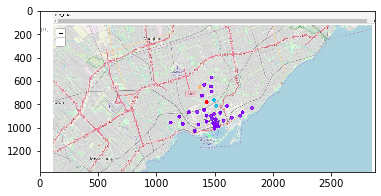

In [36]:
img_c=mpimg.imread('map_clusters.JPG')
imgplot_c = plt.imshow(img_c)
plt.show()

## Examine Clusters

Examine each cluster to see the discriminating venue categories that distinguish each cluster

In [37]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,Central Toronto,0,Pub,Light Rail Station,Coffee Shop,Spa,Supermarket,Sushi Restaurant,Bagel Shop,Sports Bar,Restaurant,Fried Chicken Joint
55,Central Toronto,0,Pub,Light Rail Station,Coffee Shop,Spa,Supermarket,Sushi Restaurant,Bagel Shop,Sports Bar,Restaurant,Fried Chicken Joint
56,Central Toronto,0,Pub,Light Rail Station,Coffee Shop,Spa,Supermarket,Sushi Restaurant,Bagel Shop,Sports Bar,Restaurant,Fried Chicken Joint
57,Central Toronto,0,Pub,Light Rail Station,Coffee Shop,Spa,Supermarket,Sushi Restaurant,Bagel Shop,Sports Bar,Restaurant,Fried Chicken Joint
58,Central Toronto,0,Pub,Light Rail Station,Coffee Shop,Spa,Supermarket,Sushi Restaurant,Bagel Shop,Sports Bar,Restaurant,Fried Chicken Joint


In [38]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,1,Coffee Shop,Bakery,Pub,Park,Theater,Mexican Restaurant,Breakfast Spot,Restaurant,Café,Shoe Store
1,Downtown Toronto,1,Coffee Shop,Gym,Park,Burger Joint,Portuguese Restaurant,Bar,Diner,Fast Food Restaurant,Beer Bar,Yoga Studio
2,Downtown Toronto,1,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Cosmetics Shop,Bakery,Restaurant,Middle Eastern Restaurant,Electronics Store,Pizza Place
3,Downtown Toronto,1,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Cosmetics Shop,Bakery,Restaurant,Middle Eastern Restaurant,Electronics Store,Pizza Place
4,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Bakery,Italian Restaurant,Breakfast Spot,Clothing Store,Park,Diner,Hotel
5,East Toronto,1,Trail,Other Great Outdoors,Health Food Store,Pub,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Women's Store
6,Downtown Toronto,1,Coffee Shop,Seafood Restaurant,Cheese Shop,Farmers Market,Beer Bar,Bakery,Steakhouse,Cocktail Bar,Café,Fountain
7,Downtown Toronto,1,Coffee Shop,Italian Restaurant,Burger Joint,Juice Bar,Japanese Restaurant,Sandwich Place,Ice Cream Shop,Bar,Salad Place,Bakery
8,Downtown Toronto,1,Grocery Store,Café,Park,Nightclub,Baby Store,Candy Store,Athletics & Sports,Italian Restaurant,Diner,Restaurant
9,Downtown Toronto,1,Coffee Shop,Thai Restaurant,Bar,Steakhouse,Café,Bakery,Restaurant,Sushi Restaurant,Concert Hall,Burger Joint


In [39]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
49,Central Toronto,2,Restaurant,Park,Playground,Tennis Court,Diner,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Women's Store
50,Central Toronto,2,Restaurant,Park,Playground,Tennis Court,Diner,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Women's Store
66,Downtown Toronto,2,Park,Playground,Trail,Women's Store,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


In [40]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
59,Downtown Toronto,3,Airport Lounge,Airport Terminal,Boutique,Harbor / Marina,Boat or Ferry,Rental Car Location,Bar,Coffee Shop,Plane,Sculpture Garden
60,Downtown Toronto,3,Airport Lounge,Airport Terminal,Boutique,Harbor / Marina,Boat or Ferry,Rental Car Location,Bar,Coffee Shop,Plane,Sculpture Garden
61,Downtown Toronto,3,Airport Lounge,Airport Terminal,Boutique,Harbor / Marina,Boat or Ferry,Rental Car Location,Bar,Coffee Shop,Plane,Sculpture Garden
62,Downtown Toronto,3,Airport Lounge,Airport Terminal,Boutique,Harbor / Marina,Boat or Ferry,Rental Car Location,Bar,Coffee Shop,Plane,Sculpture Garden
63,Downtown Toronto,3,Airport Lounge,Airport Terminal,Boutique,Harbor / Marina,Boat or Ferry,Rental Car Location,Bar,Coffee Shop,Plane,Sculpture Garden
64,Downtown Toronto,3,Airport Lounge,Airport Terminal,Boutique,Harbor / Marina,Boat or Ferry,Rental Car Location,Bar,Coffee Shop,Plane,Sculpture Garden
65,Downtown Toronto,3,Airport Lounge,Airport Terminal,Boutique,Harbor / Marina,Boat or Ferry,Rental Car Location,Bar,Coffee Shop,Plane,Sculpture Garden


In [41]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Central Toronto,4,Garden,Women's Store,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
